# Calibration of model parameters
## European puts and otko daily cliquet options

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.optimize as scpo
import time

from functions.BSpricer import BS_Pricer
from functions.MERTONpricer import Merton_pricer
from functions.KOUpricer import Kou_pricer
from functions.VGpricer import VG_pricer

Let's read the dataframe of european call options. A basket of options has been already selected in the module  `plainvanilla.py`.

In [4]:
puts_spx = pd.read_csv('data\spx_basket_puts_2016.csv')
# print(puts_spx)
# print(puts_spx['STRIKE'].values)
strikes = [1025.0, 1125.0, 1300.0, 1475.0, 1675.0, 1875.0, 2050.0, 2225.0, 2425.0, 2600.0, 2800.0] # -> [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
cond = puts_spx['STRIKE'].isin(strikes)
puts = puts_spx[cond].copy()
puts.reset_index(drop=True, inplace=True)
print(puts)

    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE   P_BID   P_ASK  STRIKE     P_IV
0   2016-01-20          1859.48  2017-01-20   11.90   14.01  1025.0  0.36992
1   2016-01-20          1859.48  2017-01-20   17.70   19.80  1125.0  0.34793
2   2016-01-20          1859.48  2017-01-20   32.91   35.21  1300.0  0.31236
3   2016-01-20          1859.48  2017-01-20   57.20   59.79  1475.0  0.27850
4   2016-01-20          1859.48  2017-01-20  101.59  104.59  1675.0  0.23958
5   2016-01-20          1859.48  2017-01-20  173.29  176.81  1875.0  0.20086
6   2016-01-20          1859.48  2017-01-20  268.89  273.00  2050.0  0.16434
7   2016-01-20          1859.48  2017-01-20  401.89  406.50  2225.0  0.10806
8   2016-01-20          1859.48  2017-01-20  588.81  594.01  2425.0  0.00059
9   2016-01-20          1859.48  2017-01-20  760.20  765.40  2600.0  0.00051
10  2016-01-20          1859.48  2017-01-20  958.80  964.10  2800.0  0.00043


Let's initialize the values for our calibration.

In [6]:
puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']

q = 0           # dividend yield
r = 0.03       # risk-free interest rate
S0 = puts.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
exercise = 'european'

puts_strikes = puts['STRIKE']    # array of K for call options
puts_prices = puts['P_Midpoint']
puts_spreads = puts['P_Spread']
weights = 1/puts_spreads**2

Then, we create the objects of the classes that develop the desired models.

In [7]:
bs_params = 0.1447
mert_params = [ 0.11156,  0.9275, -0.0795,  0.0848 ]
kou_params = [0.0932, 0.361, 0.2877, 12.5685, 3.2118]
vg_params = [0.151, 0.0107, 0.0909]

sigma = bs_params
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)

sigma, lambd, meanJ, stdJ = mert_params
Merton = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise=exercise)

sigma, lambd, p, eta1, eta2 = kou_params
Kou = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise=exercise)

sigma, theta, nu = vg_params
VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise=exercise)

In [8]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True):

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.2
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result

    if disp:
        return -1

In [9]:
IV_market = []
print(puts_prices)
for i in range(len(puts_prices)):
    IV_market.append(
        implied_volatility(puts_prices[i], S=S0, strike=puts_strikes[i], t=T, rate=0.025, q=0.05, type_o='put',
                           method='fsolve'))

print(f'Implied volatilities of market prices (puts):\nS0 = {S0}')
for index in range(len(IV_market)):
    if IV_market[index] == -1:
        IV_market[index] = 0.0
    print(f'K = {puts_strikes[index]}, IV = {round(IV_market[index], 4)}')

0      12.955
1      18.750
2      34.060
3      58.495
4     103.090
5     175.050
6     270.945
7     404.195
8     591.410
9     762.800
10    961.450
Name: P_Midpoint, dtype: float64
Implied volatilities of market prices (puts):
S0 = 1859.48
K = 1025.0, IV = 0.3702
K = 1125.0, IV = 0.3483
K = 1300.0, IV = 0.3124
K = 1475.0, IV = 0.278
K = 1675.0, IV = 0.239
K = 1875.0, IV = 0.1998
K = 2050.0, IV = 0.1636
K = 2225.0, IV = 0.1119
K = 2425.0, IV = 0.0
K = 2600.0, IV = 0.0
K = 2800.0, IV = 0.0


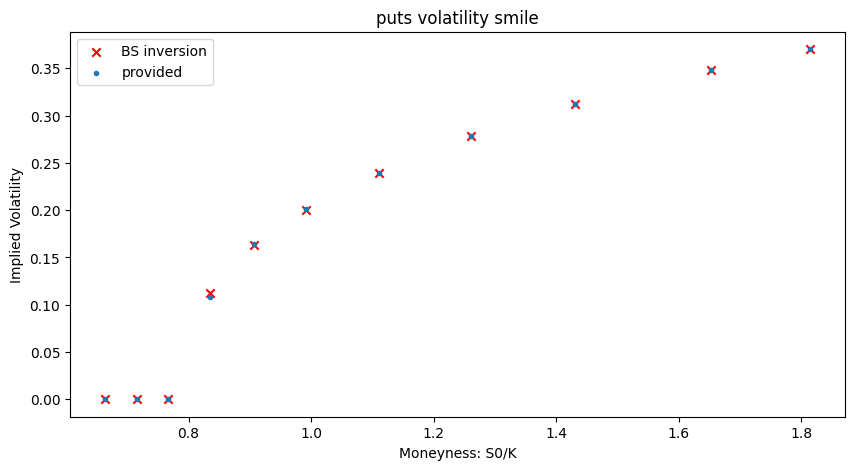

In [10]:
# Plot market implied volatilities w.r.t. log moneyness
x = (S0/puts_strikes)
# IV_filtered = [iv for iv in IV_market_p if iv != -1]
# x_filtered = [log_m for iv, log_m in zip(IV_market_p, x) if iv != -1]
IV_filtered = [iv for iv in IV_market if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market, x) if iv != -1]

fig, ax1 = plt.subplots(figsize=(10,5))

#puts
ax1.scatter(x, IV_market, marker='x', label='BS inversion', color='red')
ax1.scatter(x, puts['P_IV'], marker='.', label='provided')

ax1.set_xlabel('Moneyness: S0/K'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('puts volatility smile')

ax1.legend(); plt.show()


In [11]:
otko_spx = pd.read_csv('data/otko_spx_1year.csv')

th_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'Midpoint (%)': otko_spx['Midpoint (%)']
})
print(otko_spx)
th_mc_prices = pd.DataFrame({})
th_cf_prices = pd.DataFrame({})

otko_strikes = otko_spx[['K1', 'K2']].values / 100
otko_spreads =  otko_spx['ASK(%)'] - otko_spx['BID(%)']
otko_weights = 1/otko_spreads**2
otko_mkt_prices = otko_spx['Midpoint (%)'].values

  Starting date Stock Name Expiry  K1  K2  BID(%)  ASK(%)  Midpoint (%)
0    20/01/2016        SPX     1Y  75   0    0.17    0.20         0.185
1    20/01/2016        SPX     1Y  70   0    0.08    0.10         0.090
2    20/01/2016        SPX     1Y  85  75    0.34    0.40         0.370
3    20/01/2016        SPX     1Y  80  70    0.24    0.28         0.260
4    20/01/2016        SPX     1Y  90  80    0.48    0.54         0.510


 ### Calibration based on a basket of options

#### Merton Jump Diffusion model

In [32]:
x0 = mert_params     # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 0, -2, 0], [2, 2, 0, 5] )

def cost_function(x, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, 'put')
    sq_err = np.sum( weights*(M.closed_formula_put(p_strikes) - p_mkt_prices)**2)
    for k in range(len(o_strikes)):
        sq_err +=  otko_weights[k]*(M.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(puts_strikes, puts_prices, otko_strikes, otko_mkt_prices), bounds=bounds, method = 'trf', verbose=2)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.2735e+06                                    1.71e+08    
       1              3         3.5750e+06      3.70e+06       6.53e-02       9.73e+07    
       2              4         7.9717e+05      2.78e+06       1.11e-01       2.53e+06    
       3              5         4.9408e+05      3.03e+05       1.32e-01       2.29e+07    
       4              7         2.5622e+05      2.38e+05       5.58e-02       9.35e+05    
       5              8         2.0728e+05      4.89e+04       1.91e-02       2.42e+06    
       6             10         2.0463e+05      2.64e+03       1.30e-02       4.32e+05    
       7             11         2.0173e+05      2.91e+03       1.16e-03       3.52e+05    
       8             12         1.9694e+05      4.78e+03       2.24e-03       2.07e+05    
       9             13         1.9058e+05      6.36e+03       4.09e-03       1.09e+05    

In [38]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.2785 	 27.85%
> Calibrated Jump intensity [λ] =  0.59
> Calibrated Jump Mean =  -0.006
> Calibrated Jump St. dev.  =  0.152
TIME ELAPSED:  97.26 sec


#### Kou Jump Diffusion Model

In [ ]:
x0 = kou_params     # initial guess: [σ, λ, p, η_1, η_2]
# x0 =[0.1447, 0.9, 0.7, 2.5685, 7.75]
bounds = ( [1e-3, 1e-2, 0, 0, 0], [np.inf, 5, 0.999,  15, 15] )

# Define the objective function
def cost_function(x, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=p_strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(weights*(KOU.closed_formula_put(p_strikes) - p_mkt_prices) ** 2)
    for k in range(len(o_strikes)):
        sq_err += otko_weights[k]*(KOU.closed_formula_otko(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou = scpo.least_squares(cost_function, x0, args=(puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2)
end2 =time.time()

In [42]:

kou_params_calibrated = [round(p,4) for p in kou.x[:5]]

In [43]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.2878 	 28.78%
> Calibrated Jump intensity [λ] =  0.3
> Calibrated Upward Jump probability [p] = 0.55, [q] = 0.45
> Calibrated Rate of Exp. 1  [η_1] =  12.49
> Calibrated Rate of Exp. 2  [η_2] =  6.17
TIME ELAPSED:  -0.02 sec


#### Variance gamma model

In [44]:
x0 = vg_params
bounds = ( [1e-3, -3, 0], [3, 2, 10] )

def cost_function(x, p_strikes, p_mkt_prices, o_strikes, o_mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in p_strikes:
        prices.append(VG.closed_formula_put(k))
    sq_err = np.sum(weights*(prices - p_mkt_prices)**2)
    for k in range(len(o_strikes)):
        sq_err += otko_weights[k]* (VG.closed_formula_otko6(o_strikes[k][0], o_strikes[k][1]) - o_mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(puts_strikes, puts_prices, otko_strikes, otko_mkt_prices),  method='trf', bounds=bounds, verbose=2)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.3008e+06                                    3.75e+08    
       1              2         2.3087e+06      4.99e+06       2.38e-01       4.14e+07    
       2              3         1.0382e+06      1.27e+06       1.27e-01       4.77e+07    
       3              5         8.2641e+05      2.12e+05       3.87e-02       1.43e+07    
       4              6         6.1458e+05      2.12e+05       3.01e-02       9.59e+06    
       5              7         3.7969e+05      2.35e+05       6.36e-02       4.67e+06    
       6             10         3.6116e+05      1.85e+04       8.81e-03       4.40e+06    
       7             11         3.4253e+05      1.86e+04       8.09e-03       3.97e+06    
       8             12         3.1047e+05      3.21e+04       1.64e-02       3.19e+06    
       9             13         2.6550e+05      4.50e+04       3.34e-02       1.80e+06    

In [45]:
print('METHOD: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end3-start3,2)} sec')

METHOD: LEAST-SQUARES (trf)
> Calibrated Volatility [σ] = 0.2731, 	 27.31%
> Calibrated mean rate gamma process [θ] =  0.3931
> Calibrated variance rate gamma process [v]=  0.1358
TIME ELAPSED:  139.04 sec


### RESULTS FROM CALIBRATION

In [12]:
days = 252
paths = 5000


#### Merton Jump Diffusion

CALIBRATED PARAMETERS [σ		λ		m		v]
> European puts:	 [0.1336, 0.9675, -0.123, 0.2528]
> OTKO DC:			 [0.1336, 0.1054, -0.1649, 0.1803]
> puts + OTKO:		 [0.2785, 0.5903, -0.0063, 0.1519]


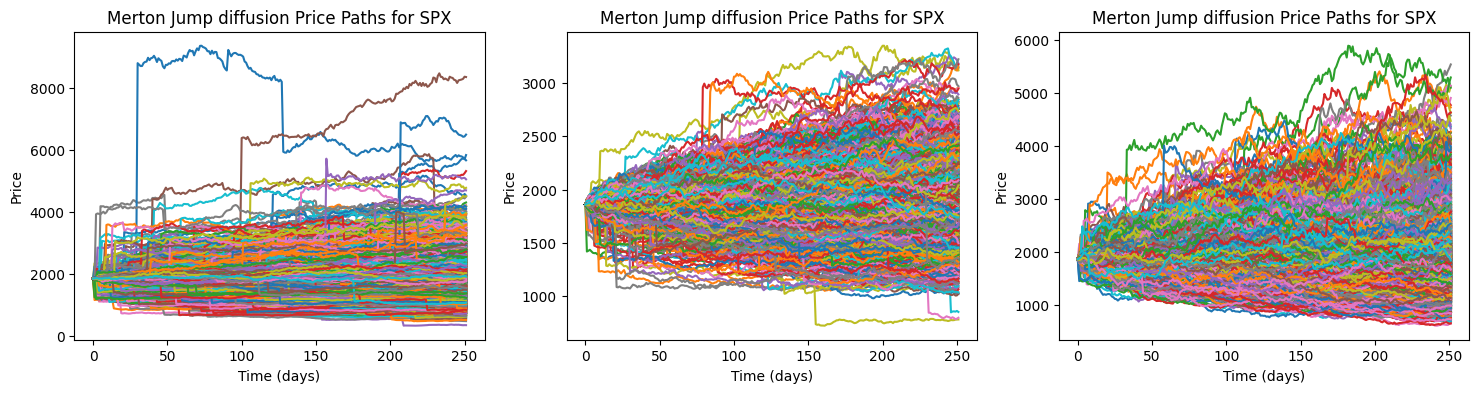

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

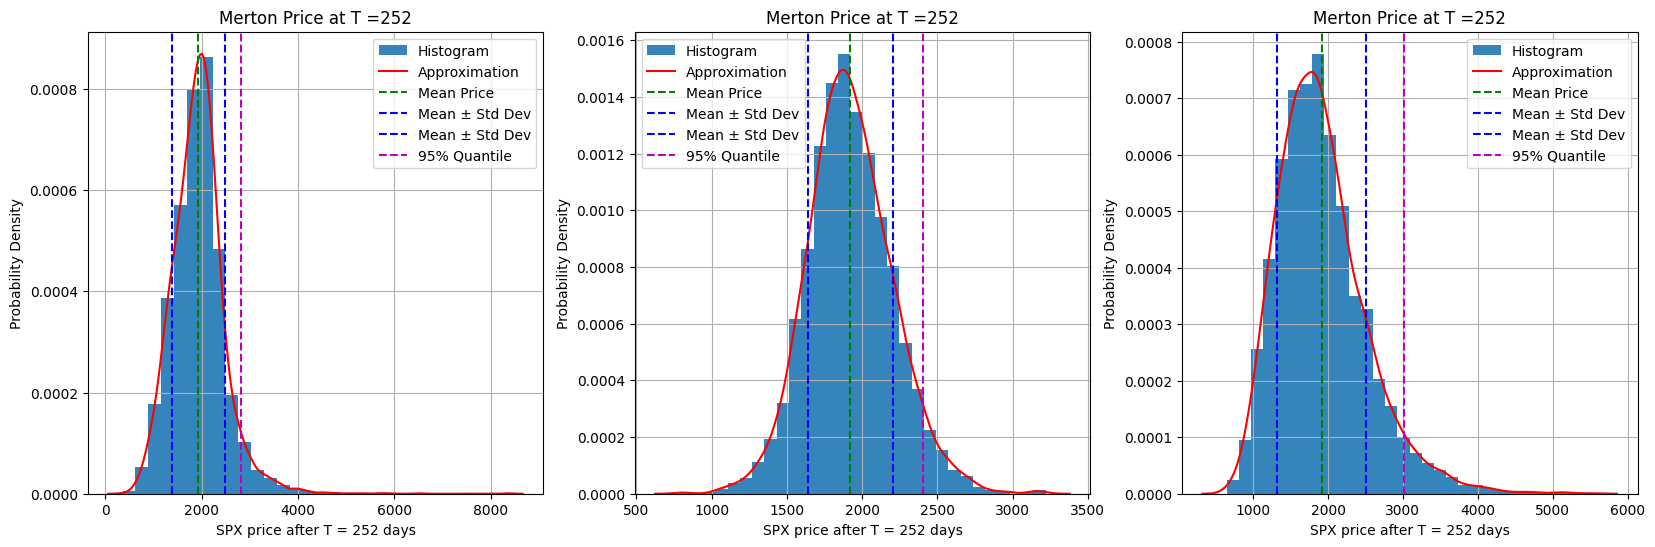

In [13]:
m_params_vanilla =[0.1336, 0.9675, -0.123, 0.2528]
m_params_otko = [0.1336, 0.1054, -0.1649, 0.1803]
#m_params_basket = mert_params_calibrated
m_params_basket = [0.2785, 0.5903, -0.0063, 0.1519]

print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> European puts:\t {m_params_vanilla}')
print(f'> OTKO DC:\t\t\t {m_params_otko}')
print(f'> puts + OTKO:\t\t {m_params_basket}')


Merton1 = Merton_pricer(S0, None, T, r, q, m_params_vanilla[0], m_params_vanilla[1], m_params_vanilla[2], m_params_vanilla[3], exercise)
Merton2 = Merton_pricer(S0, None, T, r, q, m_params_otko[0], m_params_otko[1], m_params_otko[2], m_params_otko[3], exercise)
Merton3 = Merton_pricer(S0, None, T, r, q, m_params_basket[0], m_params_basket[1], m_params_basket[2], m_params_basket[3], exercise)

SMerton1 = Merton1.MertonPath(days, paths)
SMerton2 = Merton2.MertonPath(days, paths)
SMerton3 = Merton3.MertonPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
Merton1.plotMertonPath(SMerton1, 'SPX', ax=axes[0])
Merton2.plotMertonPath(SMerton2, 'SPX', ax=axes[1])
Merton3.plotMertonPath(SMerton3, 'SPX', ax=axes[2])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
Merton1.plotMertonAtFixedTime(SMerton1, 251, 'SPX', ax = axes[0])
Merton2.plotMertonAtFixedTime(SMerton2, 251, 'SPX', ax = axes[1])
Merton3.plotMertonAtFixedTime(SMerton3, 251, 'SPX', ax = axes[2])

Finally, we find the otko prices with the calibrated parameters.

In [14]:
# OTKO PRICES
otko_calib_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'MKT_BID (%)': otko_spx['BID(%)'],
    'MKT_MID (%)': otko_spx['Midpoint (%)'],
    'MKT_ASK (%)': otko_spx['ASK(%)']
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{otko_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0         0.17        0.185         0.20
1  70   0         0.08        0.090         0.10
2  85  75         0.34        0.370         0.40
3  80  70         0.24        0.260         0.28
4  90  80         0.48        0.510         0.54


Compute the otko prices for Merton Model

In [15]:
avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton3.T:
        payoffs.append(Merton3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(otko_calib_prices))
merton_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = Merton3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['MERTON MC (%)'] = merton_mc_prices
otko_calib_prices['MERTON CF (%)'] = merton_cf_prices

print(otko_calib_prices)

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)  MERTON CF (%)
0  75   0         0.17        0.185         0.20       0.026537       0.077829
1  70   0         0.08        0.090         0.10       0.003840       0.021127
2  85  75         0.34        0.370         0.40       0.356447       0.455253
3  80  70         0.24        0.260         0.28       0.119694       0.204013
4  90  80         0.48        0.510         0.54       0.772130       0.847112


### Kou Jump Diffusion

CALIBRATED PARAMETERS: [σ		λ		p		η1		η2]
> European puts:	 [0.1556, 1.1274, 0.3878, 14.3817, 4.4284]
> OTKO DC:			 [0.1556, 0.2897, 0.304, 2.3, 7.5156]
> puts + OTKO:		 [0.2878, 0.2957, 0.5454, 12.4852, 6.1722]


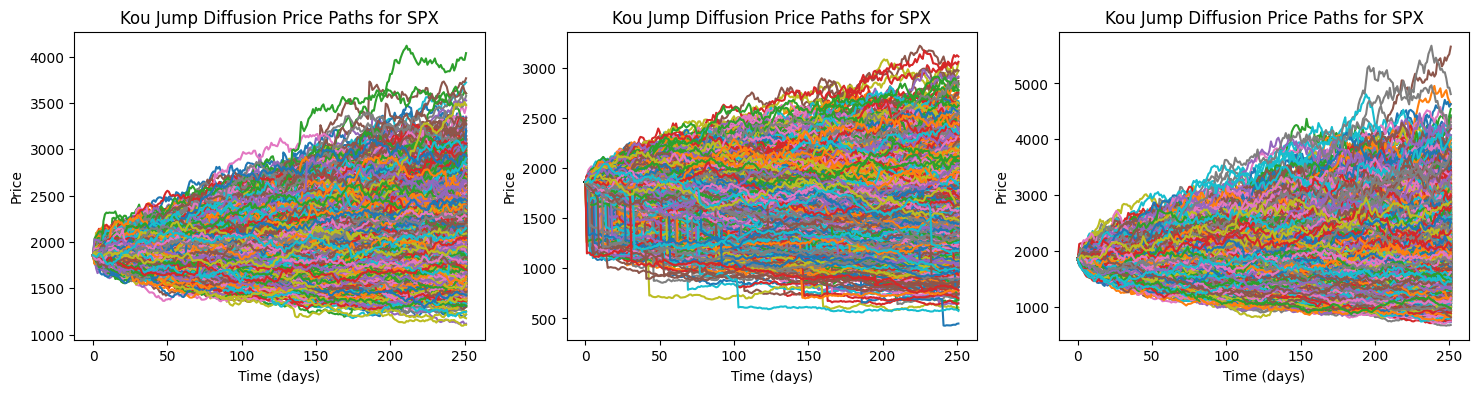

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

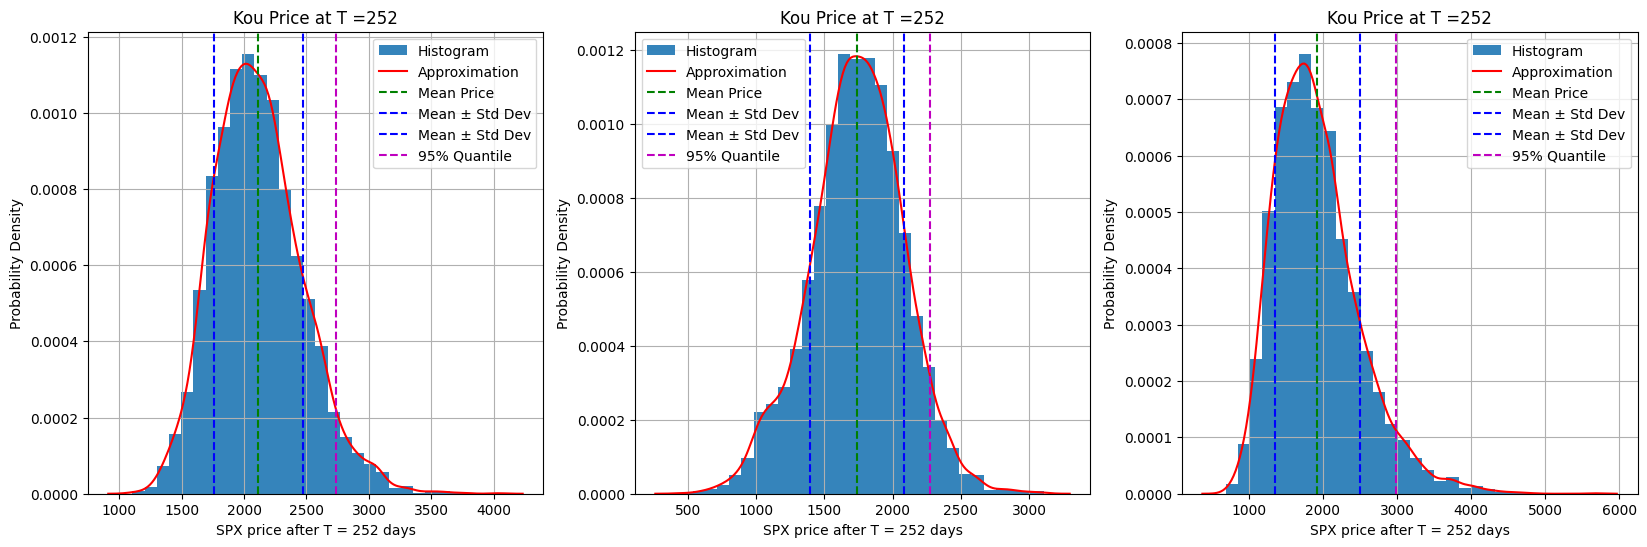

In [16]:
k_params_vanilla = [0.1556, 1.1274, 0.3878, 14.3817, 4.4284]
k_params_otko = [0.1556, 0.2897, 0.304, 2.3, 7.5156]
#k_params_basket = kou_params_calibrated
k_params_basket = [0.2878, 0.2957, 0.5454, 12.4852, 6.1722]

print(f'CALIBRATED PARAMETERS: [σ\t\tλ\t\tp\t\tη1\t\tη2]')
print(f'> European puts:\t {k_params_vanilla}')
print(f'> OTKO DC:\t\t\t {k_params_otko}')
print(f'> puts + OTKO:\t\t {k_params_basket}')


Kou1 = Kou_pricer(S0, None, T, r, k_params_vanilla[0], k_params_vanilla[1], k_params_vanilla[2], k_params_vanilla[3], k_params_vanilla[4], exercise)
Kou2 = Kou_pricer(S0, None, T, r, k_params_otko[0], k_params_otko[1], k_params_otko[2], k_params_otko[3], k_params_otko[4], exercise)
Kou3 = Kou_pricer(S0, None, T, r, k_params_basket[0], k_params_basket[1], k_params_basket[2], k_params_basket[3], k_params_basket[4], exercise)

SKou1 = Kou1.KouPath(days, paths)
SKou2 = Kou2.KouPath(days, paths)
SKou3 = Kou3.KouPath(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
Kou1.plotKouPath(SKou1, 'SPX', ax=axes[0])
Kou2.plotKouPath(SKou2, 'SPX', ax=axes[1])
Kou3.plotKouPath(SKou3, 'SPX', ax=axes[2])
plt.show()

# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
Kou1.plotKouAtFixedTime(SKou1, -1, 'SPX', ax = axes[0])
Kou2.plotKouAtFixedTime(SKou2, -1, 'SPX', ax = axes[1])
Kou3.plotKouAtFixedTime(SKou3, -1, 'SPX', ax = axes[2])

Compute the otko final prices for Kou model

In [17]:
avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou3.T:
        payoffs.append(Kou3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(otko_calib_prices))
kou_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = Kou3.closed_formula_otko(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['KOU MC (%)'] = kou_mc_prices
otko_calib_prices['KOU CF (%)'] = kou_cf_prices

print(otko_calib_prices)

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)   
0  75   0         0.17        0.185         0.20       0.026537  \
1  70   0         0.08        0.090         0.10       0.003840   
2  85  75         0.34        0.370         0.40       0.356447   
3  80  70         0.24        0.260         0.28       0.119694   
4  90  80         0.48        0.510         0.54       0.772130   

   MERTON CF (%)  KOU MC (%)  KOU CF (%)  
0       0.077829         0.0    0.220202  
1       0.021127         0.0    0.134345  
2       0.455253         0.0    0.319751  
3       0.204013         0.0    0.215430  
4       0.847112         0.0    0.463496  


#### Variance Gamma model

CALIBRATED PARAMETERS: [σ 		θ		 v]
> European puts:	 [0.2458, 0.1976, 0.921]
> OTKO DC:			 [0.1016, -0.0276, 1.735]
> puts + OTKO:		 [0.2731, 0.3931, 0.1358]
CALIBRATED PARAMETERS: [μ_p	 μ_n	v_p	v_n]
> European puts:	 [0.305, 0.108, 0.086, 0.011]
> OTKO DC:			 [0.042, 0.07, 0.003, 0.009]
> puts + OTKO:		 [0.756, 0.363, 0.078, 0.018]


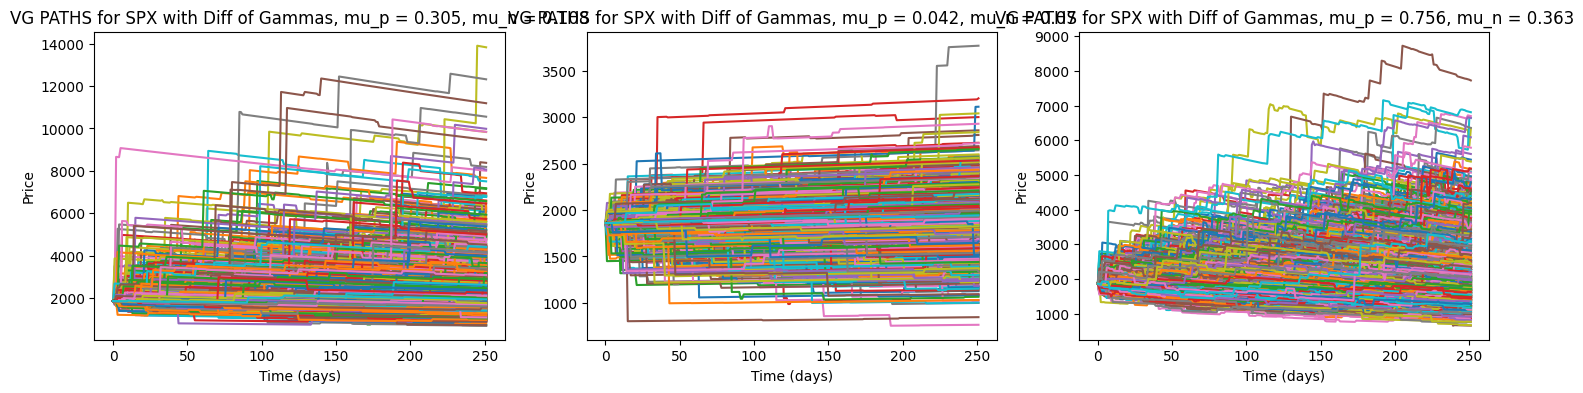

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

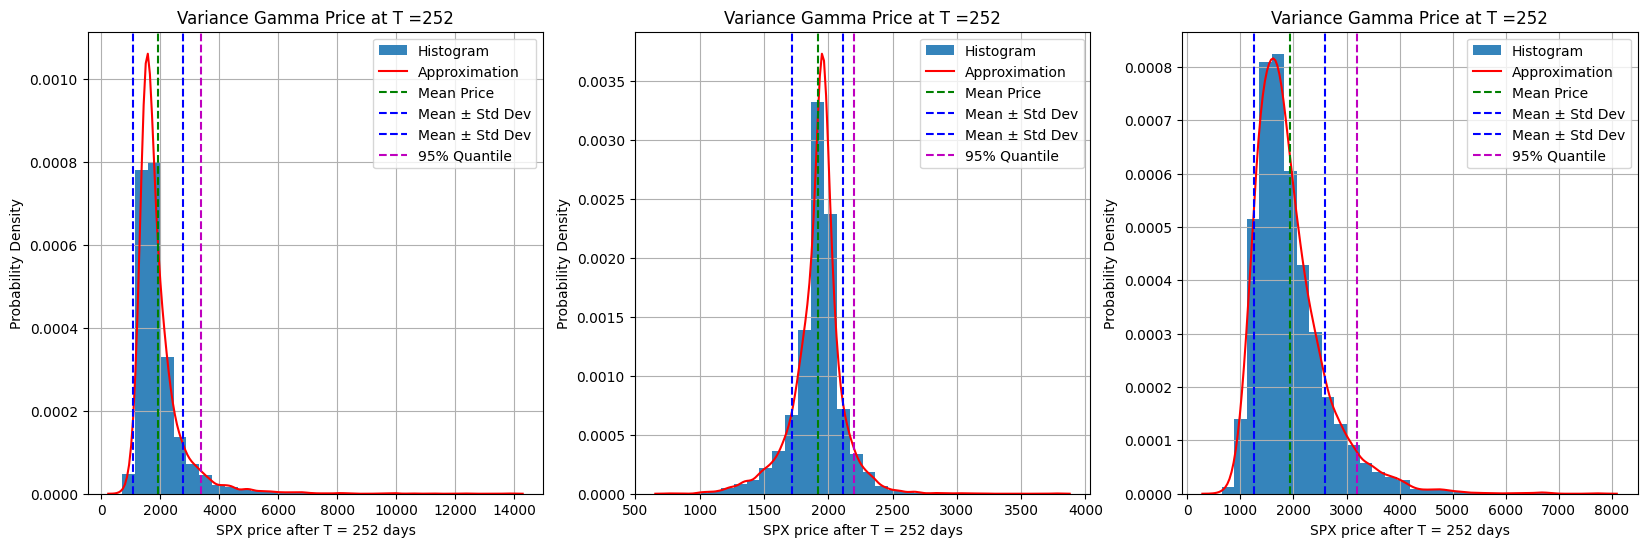

In [31]:
vg_params_vanilla =[0.2458, 0.1976, 0.921]
vg_params_otko = [0.1016, -0.0276, 1.735]
#vg_params_basket = vg_params_calibrated
vg_params_basket = [0.2731, 0.3931, 0.1358]

print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> European puts:\t {vg_params_vanilla}')
print(f'> OTKO DC:\t\t\t {vg_params_otko}')
print(f'> puts + OTKO:\t\t {vg_params_basket}')

vg_params_vanilla2 = [0.5 * np.sqrt(vg_params_vanilla[1] ** 2 + (2 * vg_params_vanilla[0] ** 2 / vg_params_vanilla[2])) + 0.5 * vg_params_vanilla[1],
                      0.5 * np.sqrt(vg_params_vanilla[1] ** 2 + (2 * vg_params_vanilla[0] ** 2 / vg_params_vanilla[2])) - 0.5 * vg_params_vanilla[1],
                      (0.5 * np.sqrt(vg_params_vanilla[1] ** 2 + (2 * vg_params_vanilla[0] ** 2 / vg_params_vanilla[2])) + 0.5 * vg_params_vanilla[1])**2 * vg_params_vanilla[2],
                      (0.5 * np.sqrt(vg_params_vanilla[1] ** 2 + (2 * vg_params_vanilla[0] ** 2 / vg_params_vanilla[2])) - 0.5 * vg_params_vanilla[1])**2 * vg_params_vanilla[2]]

vg_params_otko2 = [0.5 * np.sqrt(vg_params_otko[1] ** 2 + (2 * vg_params_otko[0] ** 2 / vg_params_otko[2])) + 0.5 * vg_params_otko[1],
                      0.5 * np.sqrt(vg_params_otko[1] ** 2 + (2 * vg_params_otko[0] ** 2 / vg_params_otko[2])) - 0.5 * vg_params_otko[1],
                      (0.5 * np.sqrt(vg_params_otko[1] ** 2 + (2 * vg_params_otko[0] ** 2 / vg_params_otko[2])) + 0.5 * vg_params_otko[1])**2 * vg_params_otko[2],
                      (0.5 * np.sqrt(vg_params_otko[1] ** 2 + (2 * vg_params_otko[0] ** 2 / vg_params_otko[2])) - 0.5 * vg_params_otko[1])**2 * vg_params_otko[2]]
vg_params_basket2 = [0.5 * np.sqrt(vg_params_basket[1] ** 2 + (2 * vg_params_basket[0] ** 2 / vg_params_basket[2])) + 0.5 * vg_params_basket[1],
                      0.5 * np.sqrt(vg_params_basket[1] ** 2 + (2 * vg_params_basket[0] ** 2 / vg_params_basket[2])) - 0.5 * vg_params_basket[1],
                      (0.5 * np.sqrt(vg_params_basket[1] ** 2 + (2 * vg_params_basket[0] ** 2 / vg_params_basket[2])) + 0.5 * vg_params_basket[1])**2 * vg_params_basket[2],
                      (0.5 * np.sqrt(vg_params_basket[1] ** 2 + (2 * vg_params_basket[0] ** 2 / vg_params_basket[2])) - 0.5 * vg_params_basket[1])**2 * vg_params_basket[2]]

for i in range(len(vg_params_vanilla2)):
    vg_params_vanilla2[i] = round(vg_params_vanilla2[i], 3)
    vg_params_otko2[i] = round(vg_params_otko2[i], 3)
    vg_params_basket2[i] = round(vg_params_basket2[i], 3)

print(f'CALIBRATED PARAMETERS: [μ_p\t μ_n\tv_p\tv_n]')
print(f'> European puts:\t {vg_params_vanilla2}')
print(f'> OTKO DC:\t\t\t {vg_params_otko2}')
print(f'> puts + OTKO:\t\t {vg_params_basket2}')


VG1 = VG_pricer(S0, None, T, r, q, vg_params_vanilla[0], vg_params_vanilla[1], vg_params_vanilla[2],  exercise)
VG2 = VG_pricer(S0, None, T, r, q, vg_params_otko[0], vg_params_otko[1], vg_params_otko[2], exercise)
VG3 = VG_pricer(S0, None, T, r, q, vg_params_basket[0], vg_params_basket[1], vg_params_basket[2], exercise)

SVG1 = VG1.VarianceGammaPath1(days, paths)
SVG2 = VG2.VarianceGammaPath1(days, paths)
SVG3 = VG3.VarianceGammaPath1(days, paths)

# PLOT MONTE CARLO PATHS
fig1, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
VG1.plotVGPath(SVG1, 'SPX', method='Diff of Gammas', ax=axes[0])
VG2.plotVGPath(SVG2, 'SPX',method='Diff of Gammas', ax=axes[1])
VG3.plotVGPath(SVG3, 'SPX', method='Diff of Gammas', ax=axes[2])
plt.tight_layout()
plt.show()


# PLOT FINAL PRICE DISTRIBUTIONS
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
VG1.plotVGAtFixedTime(SVG1, 251, 'SPX', ax = axes[0])
VG2.plotVGAtFixedTime(SVG2, 251, 'SPX', ax = axes[1])
VG3.plotVGAtFixedTime(SVG3, 251, 'SPX', ax = axes[2])

In [32]:
avg_payoffs = []
for K1, K2 in otko_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVG3.T:
        payoffs.append(VG3.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(otko_calib_prices))
vg_cf_prices = np.zeros(len(otko_calib_prices))

for index in range(len(otko_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    vg_cf_prices[index] = VG3.closed_formula_otko5(otko_strikes[index][0], otko_strikes[index][1])

otko_calib_prices['VG MC (%)'] = vg_mc_prices
otko_calib_prices['VG CF (%)'] = vg_cf_prices

In [33]:
print(otko_calib_prices)

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)   
0  75   0         0.17        0.185         0.20       0.026537  \
1  70   0         0.08        0.090         0.10       0.003840   
2  85  75         0.34        0.370         0.40       0.356447   
3  80  70         0.24        0.260         0.28       0.119694   
4  90  80         0.48        0.510         0.54       0.772130   

   MERTON CF (%)  KOU MC (%)  KOU CF (%)  VG MC (%)  VG CF (%)  
0       0.077829         0.0    0.220202   0.009757   0.009858  
1       0.021127         0.0    0.134345   0.001006   0.001913  
2       0.455253         0.0    0.319751   0.218693   0.200139  
3       0.204013         0.0    0.215430   0.053236   0.045152  
4       0.847112         0.0    0.463496   0.831127   0.801392  


### Reprice the european put options

In [34]:
# PUT PRICES MARKET VS CALIBRATED
put_calib_prices = pd.DataFrame({
    'STRIKE': puts['STRIKE'],    # array of K for call options
    'MKT_BID': puts['P_BID'],
    'MKT_MID': puts['P_Midpoint'],
    'MKT_ASK': puts['P_ASK'],

})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{put_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

    STRIKE  MKT_BID  MKT_MID  MKT_ASK
0   1025.0    11.90   12.955    14.01
1   1125.0    17.70   18.750    19.80
2   1300.0    32.91   34.060    35.21
3   1475.0    57.20   58.495    59.79
4   1675.0   101.59  103.090   104.59
5   1875.0   173.29  175.050   176.81
6   2050.0   268.89  270.945   273.00
7   2225.0   401.89  404.195   406.50
8   2425.0   588.81  591.410   594.01
9   2600.0   760.20  762.800   765.40
10  2800.0   958.80  961.450   964.10


#### Merton Jump diffusion model
Reprice the put options using calibrated parameters

In [36]:
avg_payoffs = []
for K in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton3[-1]:
        payoffs.append(Merton3.payoff_put(K, St))
    avg_payoffs.append(np.mean(payoffs))
    print(avg_payoffs)

merton_mc_prices = np.zeros(len(put_calib_prices))
merton_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = Merton3.closed_formula_put(puts_strikes[index])

put_calib_prices['MERTON MC'] = merton_mc_prices
put_calib_prices['MERTON CF'] = merton_cf_prices

[3.2836706695166833]
[3.2836706695166833, 7.4049168958709854]
[3.2836706695166833, 7.4049168958709854, 23.361879399906616]
[3.2836706695166833, 7.4049168958709854, 23.361879399906616, 54.96333320541086]
[3.2836706695166833, 7.4049168958709854, 23.361879399906616, 54.96333320541086, 115.96970584846926]
[3.2836706695166833, 7.4049168958709854, 23.361879399906616, 54.96333320541086, 115.96970584846926, 206.54220682070033]
[3.2836706695166833, 7.4049168958709854, 23.361879399906616, 54.96333320541086, 115.96970584846926, 206.54220682070033, 310.2524197956276]
[3.2836706695166833, 7.4049168958709854, 23.361879399906616, 54.96333320541086, 115.96970584846926, 206.54220682070033, 310.2524197956276, 433.23555030466457]
[3.2836706695166833, 7.4049168958709854, 23.361879399906616, 54.96333320541086, 115.96970584846926, 206.54220682070033, 310.2524197956276, 433.23555030466457, 591.3018361138357]
[3.2836706695166833, 7.4049168958709854, 23.361879399906616, 54.96333320541086, 115.96970584846926, 2

#### Kou Double Exponential Jump Diffusion model

In [37]:
avg_payoffs = []
for K in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou3[-1]:
        payoffs.append(Kou3.payoff_put(K, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(put_calib_prices))
kou_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = Kou3.closed_formula_put(puts_strikes[index])

put_calib_prices['KOU MC'] = kou_mc_prices
put_calib_prices['KOU CF'] = kou_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK   MERTON MC   MERTON CF      KOU MC   
0   1025.0    11.90   12.955    14.01    3.186624    3.072224    1.686857  \
1   1125.0    17.70   18.750    19.80    7.186069    6.920003    4.305061   
2   1300.0    32.91   34.060    35.21   22.671432   21.674563   16.579973   
3   1475.0    57.20   58.495    59.79   53.338921   51.952789   44.937008   
4   1675.0   101.59  103.090   104.59  112.542283  111.611968  102.824683   
5   1875.0   173.29  175.050   176.81  200.437962  200.460737  190.320463   
6   2050.0   268.89  270.945   273.00  301.083075  300.803496  290.390793   
7   2225.0   401.89  404.195   406.50  420.431505  419.143571  409.587392   
8   2425.0   588.81  591.410   594.01  573.826226  571.833581  563.440273   
9   2600.0   760.20  762.800   765.40  719.151409  716.871532  709.259728   
10  2800.0   958.80  961.450   964.10  894.651663  891.875553  884.953470   

        KOU CF  
0     3.664964  
1     7.641979  
2    22.454889  
3    52

#### Variance Gamma process

In [41]:
avg_payoffs = []
for K in puts_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVG3[-1]:
        payoffs.append(VG3.payoff_put(K, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(put_calib_prices))
vg_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VG3.closed_formula_put(puts_strikes[index])

put_calib_prices['VarGamma MC'] = vg_mc_prices
put_calib_prices['VarGamma CF'] = vg_cf_prices

print(put_calib_prices.iloc[:,:6])
print(put_calib_prices.iloc[:,6:10])
#print(put_calib_prices.iloc[:,1:4])

    STRIKE  MKT_BID  MKT_MID  MKT_ASK   MERTON MC   MERTON CF
0   1025.0    11.90   12.955    14.01    3.186624    3.072224
1   1125.0    17.70   18.750    19.80    7.186069    6.920003
2   1300.0    32.91   34.060    35.21   22.671432   21.674563
3   1475.0    57.20   58.495    59.79   53.338921   51.952789
4   1675.0   101.59  103.090   104.59  112.542283  111.611968
5   1875.0   173.29  175.050   176.81  200.437962  200.460737
6   2050.0   268.89  270.945   273.00  301.083075  300.803496
7   2225.0   401.89  404.195   406.50  420.431505  419.143571
8   2425.0   588.81  591.410   594.01  573.826226  571.833581
9   2600.0   760.20  762.800   765.40  719.151409  716.871532
10  2800.0   958.80  961.450   964.10  894.651663  891.875553
        KOU MC      KOU CF  VarGamma MC  VarGamma CF
0     1.686857    3.664964     1.187989     6.304490
1     4.305061    7.641979     3.554586    11.532660
2    16.579973   22.454889    15.608306    28.122724
3    44.937008   52.509950    46.527187    5